In [17]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
from sklearn.externals import joblib
import xgboost as xgb
import json
import time

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
#import matplotlib.pyplot as plt
from sklearn.utils import resample

import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
import pandas as pd
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns





In [34]:
path = "/Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/"
event = 'givenchy'
start_hour = 6


In [35]:
def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y



In [36]:
initial_features = load_pickle_file(path+str(start_hour)+'_hrs_data.pkl')
users = load_pickle_file(path+event+"_users.dat")
users.reset_index(drop =True , inplace =True)

Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/6_hrs_data.pkl
Loaded 5973 entries
Loading data file from /Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/givenchy_users.dat
Loaded 5973 entries


In [37]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [38]:
def prepare_data(initial_features):
    df = initial_features
    
    df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
    df = df.reset_index(drop=True)
    
    df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y

In [39]:
df = initial_features
    
df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
df = df.reset_index(drop=True)

df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)

# Converting all type to float, to prepare for feature selection
df = df.astype('float')
# Reset index, with drop equals to true to avoid setting old index as a new column
df = df.reset_index(drop=True)
# Visualize distribution
print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
    df['label'].value_counts()[0],
    df['label'].value_counts()[1]
))
#df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
#df.groupby(['label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')

[Original] data counts, with uninfected (0): 2569, infected (1): 3404


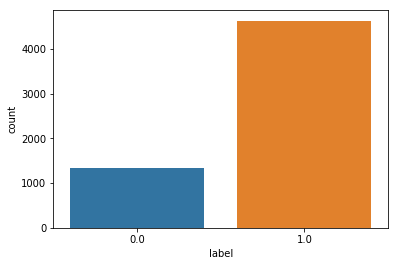

In [52]:
sns.countplot(x="label",data=df)


In [56]:
df_balanced = upsample(df)

1.0    1339
0.0    1339
Name: label, dtype: int64


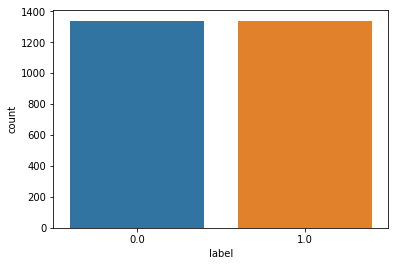

In [57]:
sns.countplot(x="label",data=df_balanced)



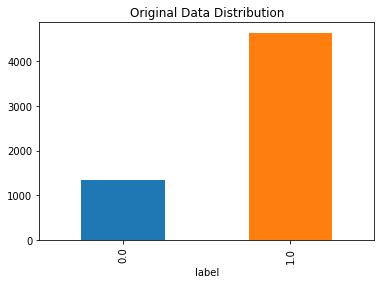

In [39]:
df.groupby(['label']).size().plot.bar(title='Original Data Distribution',y='y',x='x')

In [19]:
nf = df['label'].value_counts()

In [23]:
nf.index

Float64Index([1.0, 0.0], dtype='float64')

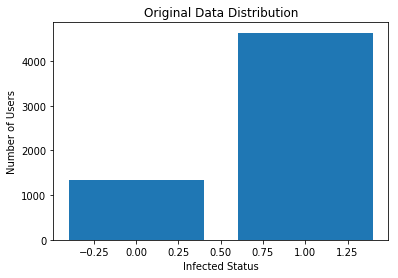

In [26]:
plt.bar(nf.index, nf)
plt.xlabel('Infected Status', fontsize=10)
plt.ylabel('Number of Users', fontsize=10)
#plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('Original Data Distribution')
plt.show()

[Original] data counts, with uninfected (0): 2569, infected (1): 3404


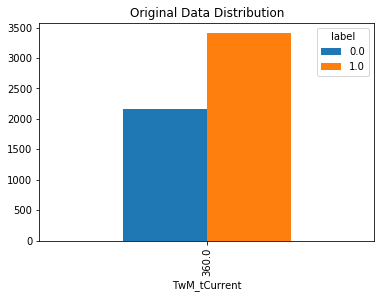

In [40]:
# 1. Prepare
df, X, y = prepare_data(initial_features)

In [41]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [42]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [43]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [44]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        #auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst

In [45]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 1000
rebalance_method = 'up'

Start cross validation
===Processing fold 0===
1.0    702
0.0    702
Name: label, dtype: int64
[0]	train-auc:0.83082	eval-auc:0.844569
[1]	train-auc:0.842667	eval-auc:0.855076
[2]	train-auc:0.842452	eval-auc:0.855461
[3]	train-auc:0.848533	eval-auc:0.854795
[4]	train-auc:0.85058	eval-auc:0.85513
[5]	train-auc:0.860855	eval-auc:0.859949
[6]	train-auc:0.863636	eval-auc:0.861104
[7]	train-auc:0.867816	eval-auc:0.862303
[8]	train-auc:0.871668	eval-auc:0.862773
[9]	train-auc:0.871851	eval-auc:0.862876
[10]	train-auc:0.873044	eval-auc:0.86348
[11]	train-auc:0.873814	eval-auc:0.86486
[12]	train-auc:0.875761	eval-auc:0.864554
[13]	train-auc:0.876918	eval-auc:0.86454
[14]	train-auc:0.876912	eval-auc:0.864277
[15]	train-auc:0.877007	eval-auc:0.864373
[16]	train-auc:0.880583	eval-auc:0.86411
[17]	train-auc:0.881316	eval-auc:0.864842
[18]	train-auc:0.881898	eval-auc:0.865114
[19]	train-auc:0.881858	eval-auc:0.86499
[20]	train-auc:0.887977	eval-auc:0.866133
[21]	train-auc:0.888733	eval-auc:0.865856

[192]	train-auc:0.908228	eval-auc:0.867258
[193]	train-auc:0.908228	eval-auc:0.867258
[194]	train-auc:0.908228	eval-auc:0.867258
[195]	train-auc:0.908228	eval-auc:0.867258
[196]	train-auc:0.908228	eval-auc:0.867258
[197]	train-auc:0.908228	eval-auc:0.867258
[198]	train-auc:0.908228	eval-auc:0.867258
[199]	train-auc:0.908228	eval-auc:0.867258
[200]	train-auc:0.908228	eval-auc:0.867258
[201]	train-auc:0.908228	eval-auc:0.867258
[202]	train-auc:0.908228	eval-auc:0.867258
[203]	train-auc:0.909704	eval-auc:0.86801
[204]	train-auc:0.909704	eval-auc:0.86801
[205]	train-auc:0.909704	eval-auc:0.86801
[206]	train-auc:0.909704	eval-auc:0.86801
[207]	train-auc:0.909704	eval-auc:0.86801
[208]	train-auc:0.909704	eval-auc:0.86801
[209]	train-auc:0.909704	eval-auc:0.86801
[210]	train-auc:0.909704	eval-auc:0.86801
[211]	train-auc:0.909704	eval-auc:0.86801
[212]	train-auc:0.909704	eval-auc:0.86801
[213]	train-auc:0.909704	eval-auc:0.86801
[214]	train-auc:0.909704	eval-auc:0.86801
[215]	train-auc:0.90970

[385]	train-auc:0.913967	eval-auc:0.867083
[386]	train-auc:0.913967	eval-auc:0.867083
[387]	train-auc:0.913967	eval-auc:0.867083
[388]	train-auc:0.913967	eval-auc:0.867083
[389]	train-auc:0.913967	eval-auc:0.867083
[390]	train-auc:0.913967	eval-auc:0.867083
[391]	train-auc:0.913967	eval-auc:0.867083
[392]	train-auc:0.913967	eval-auc:0.867083
[393]	train-auc:0.913967	eval-auc:0.867083
[394]	train-auc:0.913967	eval-auc:0.867083
[395]	train-auc:0.913967	eval-auc:0.867083
[396]	train-auc:0.913967	eval-auc:0.867083
[397]	train-auc:0.913967	eval-auc:0.867083
[398]	train-auc:0.913967	eval-auc:0.867083
[399]	train-auc:0.913967	eval-auc:0.867083
[400]	train-auc:0.913967	eval-auc:0.867083
[401]	train-auc:0.913967	eval-auc:0.867083
[402]	train-auc:0.913967	eval-auc:0.867083
[403]	train-auc:0.913967	eval-auc:0.867083
[404]	train-auc:0.913967	eval-auc:0.867083
[405]	train-auc:0.914565	eval-auc:0.867222
[406]	train-auc:0.914565	eval-auc:0.867222
[407]	train-auc:0.914565	eval-auc:0.867222
[408]	train

[576]	train-auc:0.918197	eval-auc:0.865668
[577]	train-auc:0.918197	eval-auc:0.865668
[578]	train-auc:0.918197	eval-auc:0.865668
[579]	train-auc:0.918197	eval-auc:0.865668
[580]	train-auc:0.918197	eval-auc:0.865668
[581]	train-auc:0.918197	eval-auc:0.865668
[582]	train-auc:0.918197	eval-auc:0.865668
[583]	train-auc:0.918197	eval-auc:0.865668
[584]	train-auc:0.918197	eval-auc:0.865668
[585]	train-auc:0.918197	eval-auc:0.865668
[586]	train-auc:0.918197	eval-auc:0.865668
[587]	train-auc:0.918197	eval-auc:0.865668
[588]	train-auc:0.918197	eval-auc:0.865668
[589]	train-auc:0.918197	eval-auc:0.865668
[590]	train-auc:0.918197	eval-auc:0.865668
[591]	train-auc:0.918197	eval-auc:0.865668
[592]	train-auc:0.918197	eval-auc:0.865668
[593]	train-auc:0.918197	eval-auc:0.865668
[594]	train-auc:0.918197	eval-auc:0.865668
[595]	train-auc:0.918197	eval-auc:0.865668
[596]	train-auc:0.918197	eval-auc:0.865668
[597]	train-auc:0.918197	eval-auc:0.865668
[598]	train-auc:0.918197	eval-auc:0.865668
[599]	train

[767]	train-auc:0.921111	eval-auc:0.866465
[768]	train-auc:0.921111	eval-auc:0.866465
[769]	train-auc:0.921111	eval-auc:0.866465
[770]	train-auc:0.921111	eval-auc:0.866465
[771]	train-auc:0.921111	eval-auc:0.866465
[772]	train-auc:0.921111	eval-auc:0.866465
[773]	train-auc:0.921111	eval-auc:0.866465
[774]	train-auc:0.921111	eval-auc:0.866465
[775]	train-auc:0.921111	eval-auc:0.866465
[776]	train-auc:0.921111	eval-auc:0.866465
[777]	train-auc:0.921111	eval-auc:0.866465
[778]	train-auc:0.921111	eval-auc:0.866465
[779]	train-auc:0.921111	eval-auc:0.866465
[780]	train-auc:0.921111	eval-auc:0.866465
[781]	train-auc:0.921111	eval-auc:0.866465
[782]	train-auc:0.921111	eval-auc:0.866465
[783]	train-auc:0.921111	eval-auc:0.866465
[784]	train-auc:0.921111	eval-auc:0.866465
[785]	train-auc:0.921111	eval-auc:0.866465
[786]	train-auc:0.921111	eval-auc:0.866465
[787]	train-auc:0.921111	eval-auc:0.866465
[788]	train-auc:0.921111	eval-auc:0.866465
[789]	train-auc:0.921111	eval-auc:0.866465
[790]	train

[958]	train-auc:0.924371	eval-auc:0.866782
[959]	train-auc:0.924371	eval-auc:0.866782
[960]	train-auc:0.924371	eval-auc:0.866782
[961]	train-auc:0.924371	eval-auc:0.866782
[962]	train-auc:0.924371	eval-auc:0.866782
[963]	train-auc:0.924371	eval-auc:0.866782
[964]	train-auc:0.924371	eval-auc:0.866782
[965]	train-auc:0.924371	eval-auc:0.866782
[966]	train-auc:0.924371	eval-auc:0.866782
[967]	train-auc:0.924371	eval-auc:0.866782
[968]	train-auc:0.924371	eval-auc:0.866782
[969]	train-auc:0.924371	eval-auc:0.866782
[970]	train-auc:0.924371	eval-auc:0.866782
[971]	train-auc:0.924371	eval-auc:0.866782
[972]	train-auc:0.924371	eval-auc:0.866782
[973]	train-auc:0.924371	eval-auc:0.866782
[974]	train-auc:0.924371	eval-auc:0.866782
[975]	train-auc:0.924371	eval-auc:0.866782
[976]	train-auc:0.924371	eval-auc:0.866782
[977]	train-auc:0.924371	eval-auc:0.866782
[978]	train-auc:0.924371	eval-auc:0.866782
[979]	train-auc:0.924371	eval-auc:0.866782
[980]	train-auc:0.924371	eval-auc:0.866782
[981]	train

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


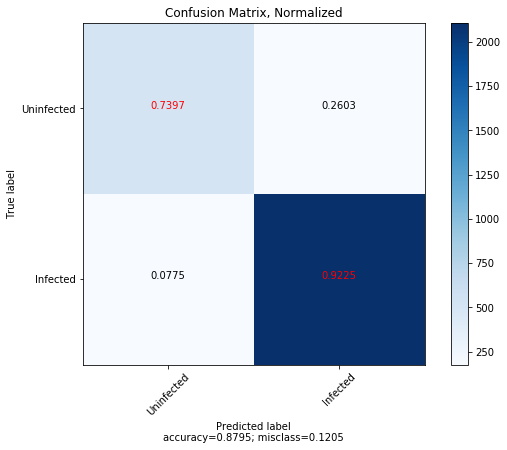

===Processing fold 1===
1.0    703
0.0    703
Name: label, dtype: int64
[0]	train-auc:0.852118	eval-auc:0.821866
[1]	train-auc:0.853621	eval-auc:0.825669
[2]	train-auc:0.854712	eval-auc:0.828204
[3]	train-auc:0.862666	eval-auc:0.832949
[4]	train-auc:0.863935	eval-auc:0.833891
[5]	train-auc:0.8658	eval-auc:0.838153
[6]	train-auc:0.866932	eval-auc:0.83956
[7]	train-auc:0.880165	eval-auc:0.844001
[8]	train-auc:0.879537	eval-auc:0.844707
[9]	train-auc:0.879399	eval-auc:0.844524
[10]	train-auc:0.880878	eval-auc:0.847898
[11]	train-auc:0.884745	eval-auc:0.849494
[12]	train-auc:0.885166	eval-auc:0.850269
[13]	train-auc:0.885653	eval-auc:0.850647
[14]	train-auc:0.887068	eval-auc:0.852176
[15]	train-auc:0.889432	eval-auc:0.852249
[16]	train-auc:0.888863	eval-auc:0.851912
[17]	train-auc:0.888957	eval-auc:0.85251
[18]	train-auc:0.891284	eval-auc:0.852932
[19]	train-auc:0.89271	eval-auc:0.852843
[20]	train-auc:0.895326	eval-auc:0.853912
[21]	train-auc:0.89587	eval-auc:0.854136
[22]	train-auc:0.896

[193]	train-auc:0.920471	eval-auc:0.862961
[194]	train-auc:0.920471	eval-auc:0.862961
[195]	train-auc:0.920471	eval-auc:0.862961
[196]	train-auc:0.920471	eval-auc:0.862961
[197]	train-auc:0.920471	eval-auc:0.862961
[198]	train-auc:0.920471	eval-auc:0.862961
[199]	train-auc:0.920548	eval-auc:0.862601
[200]	train-auc:0.920548	eval-auc:0.862601
[201]	train-auc:0.920548	eval-auc:0.862601
[202]	train-auc:0.920548	eval-auc:0.862601
[203]	train-auc:0.920548	eval-auc:0.862601
[204]	train-auc:0.920548	eval-auc:0.862601
[205]	train-auc:0.920548	eval-auc:0.862601
[206]	train-auc:0.920548	eval-auc:0.862601
[207]	train-auc:0.920548	eval-auc:0.862601
[208]	train-auc:0.920548	eval-auc:0.862601
[209]	train-auc:0.920548	eval-auc:0.862601
[210]	train-auc:0.920548	eval-auc:0.862601
[211]	train-auc:0.920548	eval-auc:0.862601
[212]	train-auc:0.920548	eval-auc:0.862601
[213]	train-auc:0.920548	eval-auc:0.862601
[214]	train-auc:0.920548	eval-auc:0.862601
[215]	train-auc:0.920548	eval-auc:0.862601
[216]	train

[384]	train-auc:0.924507	eval-auc:0.863134
[385]	train-auc:0.924507	eval-auc:0.863134
[386]	train-auc:0.924507	eval-auc:0.863134
[387]	train-auc:0.924507	eval-auc:0.863134
[388]	train-auc:0.924507	eval-auc:0.863134
[389]	train-auc:0.924507	eval-auc:0.863134
[390]	train-auc:0.924507	eval-auc:0.863134
[391]	train-auc:0.924507	eval-auc:0.863134
[392]	train-auc:0.924507	eval-auc:0.863134
[393]	train-auc:0.924507	eval-auc:0.863134
[394]	train-auc:0.924507	eval-auc:0.863134
[395]	train-auc:0.924507	eval-auc:0.863134
[396]	train-auc:0.924507	eval-auc:0.863134
[397]	train-auc:0.924507	eval-auc:0.863134
[398]	train-auc:0.924507	eval-auc:0.863134
[399]	train-auc:0.924507	eval-auc:0.863134
[400]	train-auc:0.924507	eval-auc:0.863134
[401]	train-auc:0.924507	eval-auc:0.863134
[402]	train-auc:0.924507	eval-auc:0.863134
[403]	train-auc:0.924507	eval-auc:0.863134
[404]	train-auc:0.924507	eval-auc:0.863134
[405]	train-auc:0.924507	eval-auc:0.863134
[406]	train-auc:0.924507	eval-auc:0.863134
[407]	train

[577]	train-auc:0.925643	eval-auc:0.86351
[578]	train-auc:0.925643	eval-auc:0.86351
[579]	train-auc:0.925643	eval-auc:0.86351
[580]	train-auc:0.925643	eval-auc:0.86351
[581]	train-auc:0.925643	eval-auc:0.86351
[582]	train-auc:0.925643	eval-auc:0.86351
[583]	train-auc:0.925643	eval-auc:0.86351
[584]	train-auc:0.925643	eval-auc:0.86351
[585]	train-auc:0.925643	eval-auc:0.86351
[586]	train-auc:0.925643	eval-auc:0.86351
[587]	train-auc:0.925643	eval-auc:0.86351
[588]	train-auc:0.925643	eval-auc:0.86351
[589]	train-auc:0.925643	eval-auc:0.86351
[590]	train-auc:0.925643	eval-auc:0.86351
[591]	train-auc:0.925643	eval-auc:0.86351
[592]	train-auc:0.925643	eval-auc:0.86351
[593]	train-auc:0.925643	eval-auc:0.86351
[594]	train-auc:0.925643	eval-auc:0.86351
[595]	train-auc:0.925643	eval-auc:0.86351
[596]	train-auc:0.925643	eval-auc:0.86351
[597]	train-auc:0.925643	eval-auc:0.86351
[598]	train-auc:0.925643	eval-auc:0.86351
[599]	train-auc:0.925643	eval-auc:0.86351
[600]	train-auc:0.925643	eval-auc:

[769]	train-auc:0.927737	eval-auc:0.863237
[770]	train-auc:0.927737	eval-auc:0.863237
[771]	train-auc:0.927737	eval-auc:0.863237
[772]	train-auc:0.927737	eval-auc:0.863237
[773]	train-auc:0.927737	eval-auc:0.863237
[774]	train-auc:0.927737	eval-auc:0.863237
[775]	train-auc:0.927737	eval-auc:0.863237
[776]	train-auc:0.927737	eval-auc:0.863237
[777]	train-auc:0.927737	eval-auc:0.863237
[778]	train-auc:0.927737	eval-auc:0.863237
[779]	train-auc:0.927737	eval-auc:0.863237
[780]	train-auc:0.927737	eval-auc:0.863237
[781]	train-auc:0.927737	eval-auc:0.863237
[782]	train-auc:0.927737	eval-auc:0.863237
[783]	train-auc:0.927737	eval-auc:0.863237
[784]	train-auc:0.927737	eval-auc:0.863237
[785]	train-auc:0.927737	eval-auc:0.863237
[786]	train-auc:0.927737	eval-auc:0.863237
[787]	train-auc:0.927737	eval-auc:0.863237
[788]	train-auc:0.927737	eval-auc:0.863237
[789]	train-auc:0.927737	eval-auc:0.863237
[790]	train-auc:0.927737	eval-auc:0.863237
[791]	train-auc:0.927737	eval-auc:0.863237
[792]	train

[961]	train-auc:0.92854	eval-auc:0.863477
[962]	train-auc:0.92854	eval-auc:0.863477
[963]	train-auc:0.92854	eval-auc:0.863477
[964]	train-auc:0.92854	eval-auc:0.863477
[965]	train-auc:0.92854	eval-auc:0.863477
[966]	train-auc:0.92854	eval-auc:0.863477
[967]	train-auc:0.92854	eval-auc:0.863477
[968]	train-auc:0.92854	eval-auc:0.863477
[969]	train-auc:0.92854	eval-auc:0.863477
[970]	train-auc:0.92854	eval-auc:0.863477
[971]	train-auc:0.92854	eval-auc:0.863477
[972]	train-auc:0.92854	eval-auc:0.863477
[973]	train-auc:0.92854	eval-auc:0.863477
[974]	train-auc:0.92854	eval-auc:0.863477
[975]	train-auc:0.92854	eval-auc:0.863477
[976]	train-auc:0.92854	eval-auc:0.863477
[977]	train-auc:0.92854	eval-auc:0.863477
[978]	train-auc:0.92854	eval-auc:0.863477
[979]	train-auc:0.92854	eval-auc:0.863477
[980]	train-auc:0.929574	eval-auc:0.863124
[981]	train-auc:0.929574	eval-auc:0.863124
[982]	train-auc:0.929651	eval-auc:0.862881
[983]	train-auc:0.929651	eval-auc:0.862881
[984]	train-auc:0.929651	eval-

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


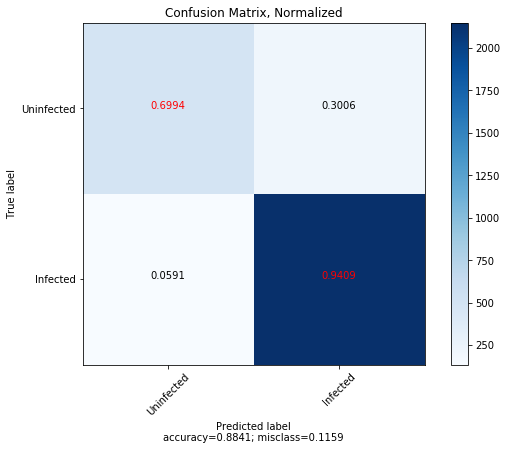

Finished cross validation
MSE: 0    0.112585
dtype: float64 
ACC: 0    0.881802
dtype: float64 
AUC: 0    0.864831
dtype: float64 
ACC for t at 210: 0   NaN
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [13]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

In [46]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

1.0    2569
0.0    2569
Name: label, dtype: int64


In [47]:
with open(path+event+'_xgb_model_'+str(start_hour)+'_hrs.dat', 'wb') as file:
    pickle.dump(model, file)